**Chapter 3 – Kaggle Titantic dataset**

*The task is to predict which passengers survived the Titanic shipwreck.*

*In this challenge, we are asked to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).*

*This notebook contains all the code for tackling the titanic dataset on Kaggle*

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [114]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "titantic"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

Forget this step for now. Its seems this can work well if you download public and personal datasets, but I'm struggling to download the competition dataset. Currently it downloads them but it only downloads the zip file. Then some magic commands would need to be run to unzip them which wouldn't be too difficult

In [115]:
import os
import kaggle

TITANIC_PATH = os.path.join("datasets", "titanic")

kaggle.api.authenticate()

def fetch_titanic_data(titanic_path=TITANIC_PATH):
    if not os.path.isdir(titanic_path):
        os.makedirs(titanic_path)

In [116]:
fetch_titanic_data()

kaggle.api.authenticate()
kaggle.api.competition_download_files('titanic', path=TITANIC_PATH)

from zipfile import ZipFile

file_name = '/titanic.zip'

with ZipFile(TITANIC_PATH + file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()   
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall(path=TITANIC_PATH) 
    print('Done!') 

File Name                                             Modified             Size
gender_submission.csv                          2019-12-11 02:17:12         3258
test.csv                                       2019-12-11 02:17:12        28629
train.csv                                      2019-12-11 02:17:12        61194
Extracting all the files now...
Done!


In [117]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [118]:
train_data = load_titanic_data(filename="train.csv")
test_data = load_titanic_data(filename="test.csv")

The data is already split into a training set and a test set. However, the test data does not contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [119]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's get more info to see how much data is missing:

In [120]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Ok the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [121]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Only 38% **Survived**. :( That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was 32.20 pounds, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [122]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [123]:
train_data["Name"].value_counts()

Davies, Mr. Alfred J                            1
Ringhini, Mr. Sante                             1
Harris, Mrs. Henry Birkhardt (Irene Wallach)    1
Laroche, Miss. Simonne Marie Anne Andree        1
Skoog, Miss. Mabel                              1
                                               ..
Sedgwick, Mr. Charles Frederick Waddington      1
Dowdell, Miss. Elizabeth                        1
Davis, Miss. Mary                               1
Jussila, Mr. Eiriik                             1
Sage, Mr. George John Jr                        1
Name: Name, Length: 891, dtype: int64

In [124]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [125]:
train_data["Ticket"].value_counts()

1601          7
CA. 2343      7
347082        7
CA 2144       6
347088        6
             ..
236852        1
36209         1
349910        1
113783        1
A./5. 3235    1
Name: Ticket, Length: 681, dtype: int64

In [126]:
train_data["Cabin"].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
D              3
F2             3
              ..
E50            1
A34            1
C99            1
D46            1
A14            1
Name: Cabin, Length: 147, dtype: int64

In [127]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Saving figure attribute_histogram_plots


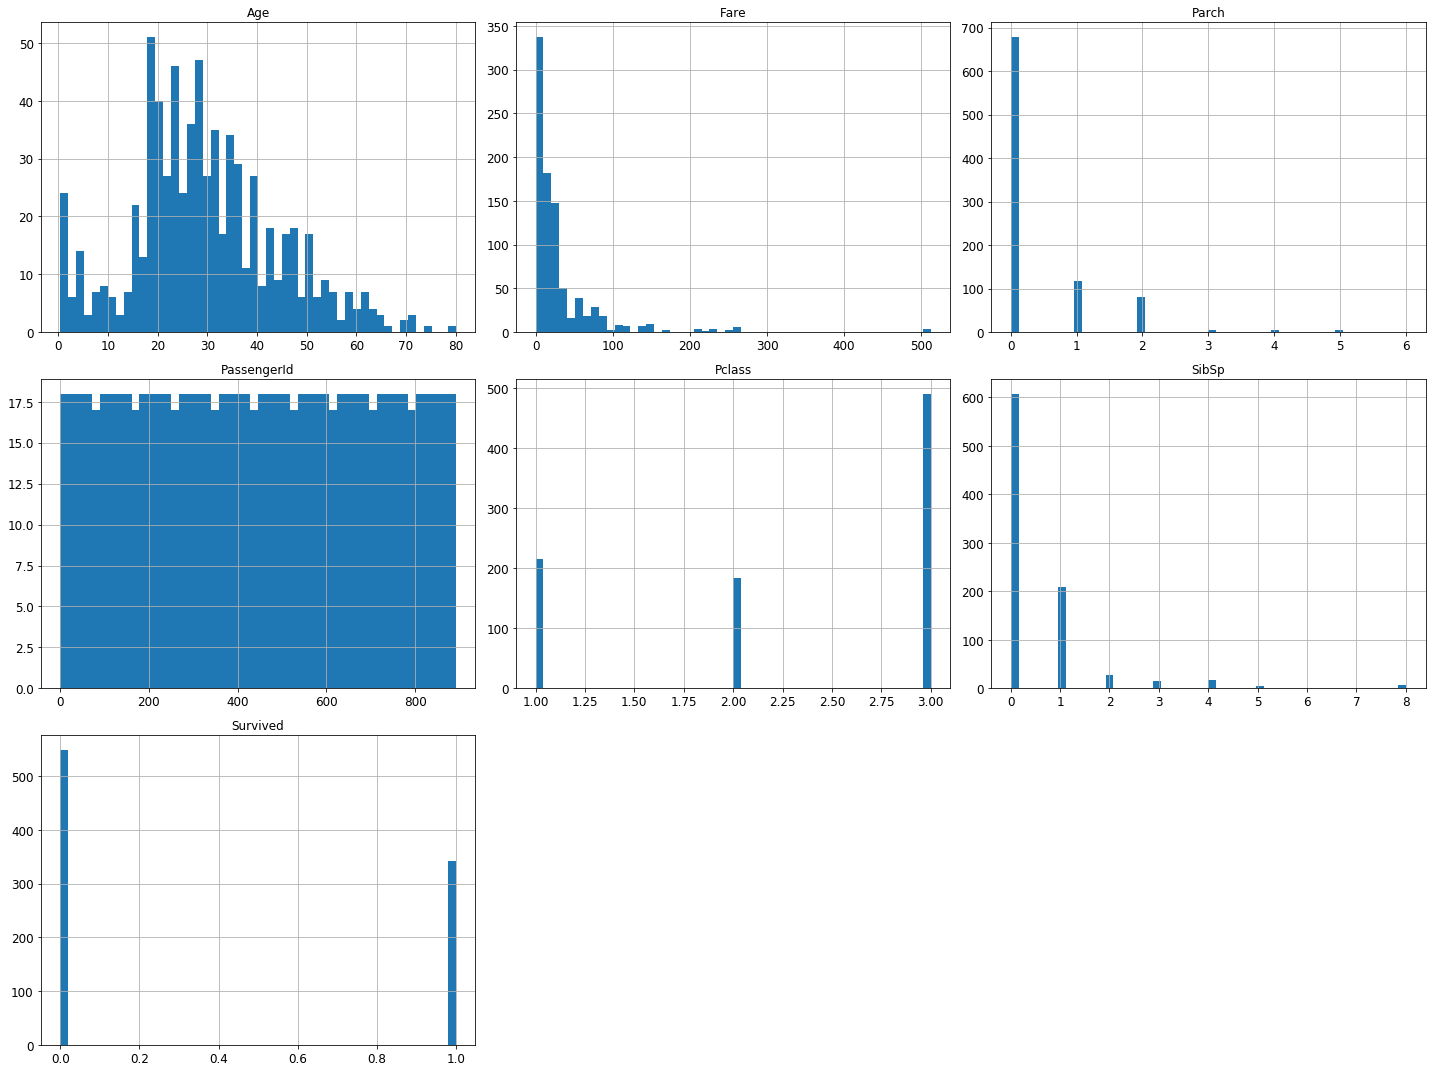

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
titanic.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# Discover and Visualise the data to gain insights

## Looking for correlations

In [154]:
titanic = train_data.copy()

corr_matrix = titanic.corr()

corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [155]:
corr_matrix.columns.to_list()

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff54c7b5a60>,
      dtype=object)

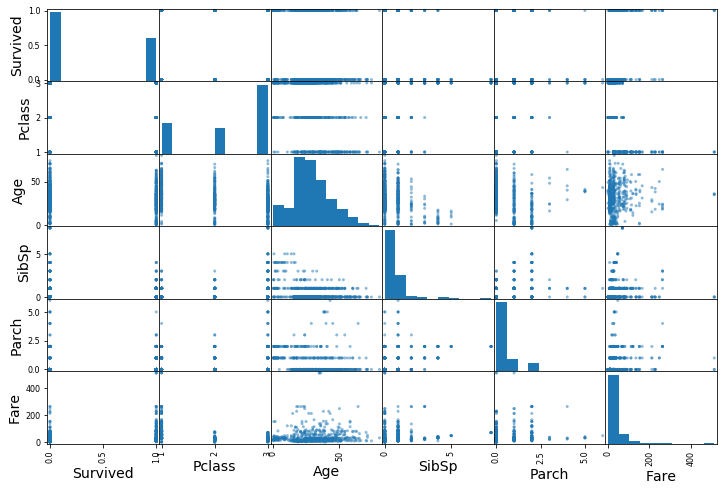

In [156]:
from pandas.plotting import scatter_matrix

attributes = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
scatter_matrix(train_data[attributes], figsize=(12,8))

# Prepare the data for Machine Learning algorithms

In preparation for ML we need to consider the following:
* scaling features so ML algorithms perform better
* dropping useless features that only create noise
* keeping more related features can check their correlation with the target label
* creating new features
* numerically encodoing categorical features

We will perform these data transform tasks using pipelines so they can be easily re-used for inference on the test set, and also final deployment if required.
Although for development if may not be required. Instead could manually perform these steps. Bowen mentioned he creates a custom class for these, which he normally can just import in future projects.

In [159]:
# first create a copy of the data
titanic = train_data.drop("Survived", axis=1)
titanic_labels = train_data["Survived"].copy()

In [195]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [267]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # The chapter solutions did not use this

num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])),
    ('imputer', SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(cat_attributes_keep)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('cat_encoder', OneHotEncoder())
])

In [268]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


num_attributes = titanic.select_dtypes(exclude=['object']).columns.to_list()
cat_attributes = titanic.select_dtypes(include=['object']).columns.to_list()
cat_attributes_keep = ['Sex', 'Embarked']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes)
])

In [275]:
X_train = full_pipeline.fit_transform(titanic)
y_train = titanic_labels

# Select and train a model

Now we're ready to train a classifier, let's start with linearRegressor

In [276]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Great our model is trained, let's use it to make predictions on the test set

In [277]:
X_test = full_pipeline.transform(test_data)
y_pred = lin_reg.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [281]:
from sklearn.model_selection import cross_val_score

lin_reg_scores = cross_val_score(lin_reg, X_train, y_train, cv=10)
lin_reg_scores.mean()

0.3629633755233653

In [285]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [286]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7307365792759051

In [287]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149063670411986

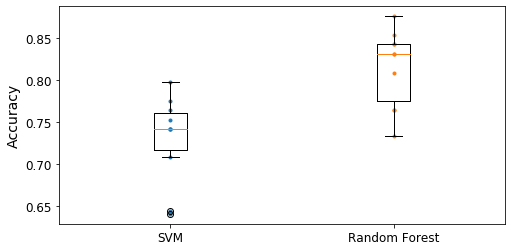

In [290]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()